# Multi-class classification based on Softmax and Cross-Entropy using pytorch

## import libraries

In [330]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import random
import os

## load data

In [331]:
directory_data  = './data/'
filename_data   = 'assignment_06_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))

x_train = data['x_train']
y_train = data['y_train']

x_test  = data['x_test']
y_test  = data['y_test']

num_data_train  = x_train.shape[0]
num_data_test   = x_test.shape[0]

print('*************************************************')
print('size of x_train :', x_train.shape)
print('size of y_train :', y_train.shape)
print('*************************************************')
print('size of x_test :', x_test.shape)
print('size of y_test :', y_test.shape)
print('*************************************************')
print('number of training image :', x_train.shape[0])
print('height of training image :', x_train.shape[1])
print('width of training image :', x_train.shape[2])
print('*************************************************')
print('number of testing image :', x_test.shape[0])
print('height of testing image :', x_test.shape[1])
print('width of testing image :', x_test.shape[2])
print('*************************************************')

*************************************************
size of x_train : (20000, 32, 32)
size of y_train : (20000,)
*************************************************
size of x_test : (8000, 32, 32)
size of y_test : (8000,)
*************************************************
number of training image : 20000
height of training image : 32
width of training image : 32
*************************************************
number of testing image : 8000
height of testing image : 32
width of testing image : 32
*************************************************


## number of classes

In [332]:
print('*************************************************')
print('number of classes :', len(set(y_train)))
print('*************************************************')

*************************************************
number of classes : 10
*************************************************


## hyper-parameters

In [333]:
device          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

number_epoch    = 10
# number_epoch    = 100
size_minibatch  = 32
learning_rate   = 0.001
weight_decay    = 1e-2

## custom data loader for the PyTorch framework

In [334]:
class dataset(Dataset):
    
    def __init__(self, image, label):
        
        self.image  = image
        self.label  = label.astype(np.long)
    
    def __getitem__(self, index):
        
        image   = self.image[index, :, :]
        label   = self.label[index, ]

        image   = torch.FloatTensor(image).unsqueeze(dim=0)
        label   = torch.LongTensor([label])

        return image, label
    
    def __len__(self):
        
        return self.image.shape[0]

    def collate_fn(self, batch):
        images  = list()
        labels  = list()

        for b in batch:
            images.append(b[0])
            labels.append(b[1])

        images  = torch.stack(images, dim=0)
        labels  = torch.stack(labels, dim=0).squeeze()

        return images, labels
        

## construct datasets and dataloaders for training and testing

In [335]:
dataset_train   = dataset(x_train, y_train)
dataset_test    = dataset(x_test, y_test)

dataloader_train    = torch.utils.data.DataLoader(dataset_train, batch_size=size_minibatch, shuffle=True, drop_last=True, collate_fn=dataset_train.collate_fn)
dataloader_test     = torch.utils.data.DataLoader(dataset_test, batch_size=size_minibatch, shuffle=True, drop_last=True, collate_fn=dataset_test.collate_fn)

## shape of the data when using the data loader

In [336]:
image, label    = next(iter(dataloader_train))
print('************************************************************')
print('size of mini-batch of the image:', image.shape)
print('************************************************************')
print('size of mini-batch of the label:', label.shape)
print('************************************************************')

************************************************************
size of mini-batch of the image: torch.Size([32, 1, 32, 32])
************************************************************
size of mini-batch of the label: torch.Size([32])
************************************************************


## class for the neural network 

In [337]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
    
        self.layer1 = nn.Sequential( 
            nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3, padding=1, bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=128),
            nn.Dropout2d(0.1),
            nn.Conv2d(in_channels=128, out_channels=4, kernel_size=1, padding=1, bias=True)
        )

        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1, bias=True)
        self.bn2 = nn.BatchNorm2d(num_features=16)
        
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1, bias=True)
        self.bn3 = nn.BatchNorm2d(num_features=16)
        
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, bias=True)
        self.bn4 = nn.BatchNorm2d(num_features=32)
       
        self.pool2 = nn.MaxPool2d(2, 2)

        self.tns2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=1, padding=1, bias=True)
        
        self.conv5 = nn.Conv2d(in_channels=16, out_channels=16,kernel_size=3, padding=1, bias=True)
        self.bn5 = nn.BatchNorm2d(num_features=16)
        
        self.conv6 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, bias=True)
        self.bn6 = nn.BatchNorm2d(num_features=32)
        
        self.conv7 = nn.Conv2d(in_channels=32, out_channels=10, kernel_size=1, padding=1, bias=True)
        self.gpool = nn.AvgPool2d(kernel_size=7)
        self.drop = nn.Dropout2d(0.1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.drop(self.bn2(torch.nn.functional.relu(self.conv2(x))))
        x = self.pool1(x)
        x = self.drop(self.bn3(torch.nn.functional.relu(self.conv3(x))))
        x = self.drop(self.bn4(torch.nn.functional.relu(self.conv4(x))))
        x = self.tns2(self.pool2(x))
        x = self.drop(self.bn5(torch.nn.functional.relu(self.conv5(x))))
        x = self.drop(self.bn6(torch.nn.functional.relu(self.conv6(x))))
        x = self.conv7(x)
        x = self.gpool(x)
        x = x.view(-1, 10)
        return torch.nn.functional.log_softmax(x)

  
    # def __init__(self):
    #     super(Classifier, self).__init__()

    #     self.feature    = nn.Sequential(
    #         nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1, padding=1, bias=True),
    #         nn.MaxPool2d(kernel_size=2, stride=2),
    #         nn.ReLU(),

    #         nn.Conv2d(in_channels=2, out_channels=4, kernel_size=3, stride=1, padding=1, bias=True),
    #         nn.MaxPool2d(kernel_size=2, stride=2),
    #         nn.ReLU(),

    #         nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1, bias=True),
    #         nn.MaxPool2d(kernel_size=2, stride=2),
    #         nn.ReLU(),
    #     )

    #     self.classifier = nn.Sequential(
    #         nn.Linear(128, 64, bias=True),
    #         nn.ReLU(),
    #         nn.Linear(64, 10, bias=True),
    #     )

    #     self.network    = nn.Sequential(
    #         self.feature,
    #         nn.Flatten(),
    #         self.classifier,
    #     )

    #     self.initialize()


    # def initialize(self):

    #     for m in self.network.modules():

    #         if isinstance(m, nn.Conv2d):

    #             nn.init.constant_(m.weight, 0.01)
    #             nn.init.constant_(m.bias, 1)

    #         elif isinstance(m, nn.Linear):

    #             nn.init.constant_(m.weight, 0.01)
    #             nn.init.constant_(m.bias, 1)


    # def forward(self, input):

    #     output = self.network(input)

    #     return output


    # def __init__(self):
    #     super(Classifier, self).__init__()
    
    #     self.conv1 = nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3, padding=1, bias=True)
    #     self.bn1 = nn.BatchNorm2d(num_features=128)

    #     self.tns1 = nn.Conv2d(in_channels=128, out_channels=4, kernel_size=1, padding=1, bias=True)

    #     self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1, bias=True)
    #     self.bn2 = nn.BatchNorm2d(num_features=16)
        
    #     self.pool1 = nn.MaxPool2d(2, 2)

    #     self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1, bias=True)
    #     self.bn3 = nn.BatchNorm2d(num_features=16)
        
    #     self.conv4 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, bias=True)
    #     self.bn4 = nn.BatchNorm2d(num_features=32)
       
    #     self.pool2 = nn.MaxPool2d(2, 2)

    #     self.tns2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=1, padding=1, bias=True)
        
    #     self.conv5 = nn.Conv2d(in_channels=16, out_channels=16,kernel_size=3, padding=1, bias=True)
    #     self.bn5 = nn.BatchNorm2d(num_features=16)
        
    #     self.conv6 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, bias=True)
    #     self.bn6 = nn.BatchNorm2d(num_features=32)
        
    #     self.conv7 = nn.Conv2d(in_channels=32, out_channels=10, kernel_size=1, padding=1, bias=True)
    #     self.gpool = nn.AvgPool2d(kernel_size=7)
    #     self.drop = nn.Dropout2d(0.1)

    # def forward(self, x):
    #     x = self.tns1(self.drop(self.bn1(torch.nn.functional.relu(self.conv1(x)))))
    #     x = self.drop(self.bn2(torch.nn.functional.relu(self.conv2(x))))
    #     x = self.pool1(x)
    #     x = self.drop(self.bn3(torch.nn.functional.relu(self.conv3(x))))
    #     x = self.drop(self.bn4(torch.nn.functional.relu(self.conv4(x))))
    #     x = self.tns2(self.pool2(x))
    #     x = self.drop(self.bn5(torch.nn.functional.relu(self.conv5(x))))
    #     x = self.drop(self.bn6(torch.nn.functional.relu(self.conv6(x))))
    #     x = self.conv7(x)
    #     x = self.gpool(x)
    #     x = x.view(-1, 10)
    #     return torch.nn.functional.log_softmax(x)

## build network

In [338]:
classifier  = Classifier().to(device)
optimizer   = torch.optim.SGD(classifier.parameters(), lr=learning_rate, weight_decay=weight_decay)

## print the defined neural network

In [339]:
print(classifier)

Classifier(
  (layer1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.1, inplace=False)
    (4): Conv2d(128, 4, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  )
  (conv2): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1,

## compute the prediction

In [340]:
def compute_prediction(model, input):

    prediction = model(input)

    return prediction

## compute the loss

In [341]:
def compute_loss(prediction, label):

    criterion   = nn.CrossEntropyLoss()
    loss        = criterion(prediction, label)
    loss_value  = loss.item()

    return loss, loss_value

## compute the accuracy

In [342]:
def compute_accuracy(prediction, label):
    # ================================================================================ 
    # complete the function body 
    
    pred = torch.argmax(prediction, dim=1)
    equal = torch.eq(pred, label)
    accuracy    = (torch.sum(equal) / len(equal)).item()

    # ================================================================================ 

    return accuracy

## variables for the learning curve

In [343]:
loss_mean_train     = np.zeros(number_epoch)
loss_std_train      = np.zeros(number_epoch)
accuracy_mean_train = np.zeros(number_epoch)
accuracy_std_train  = np.zeros(number_epoch)

loss_mean_test      = np.zeros(number_epoch)
loss_std_test       = np.zeros(number_epoch)
accuracy_mean_test  = np.zeros(number_epoch)
accuracy_std_test   = np.zeros(number_epoch)

## train and test

In [344]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    loss_train_epoch        = []
    accuracy_train_epoch    = []

    classifier.train()

    for index_batch, (image_train, label_train) in enumerate(dataloader_train):

        image_train = image_train.to(device)
        label_train = label_train.to(device)
        
        prediction_train                = compute_prediction(classifier, image_train)
        loss_train, loss_value_train    = compute_loss(prediction_train, label_train)
        accuracy_train                  = compute_accuracy(prediction_train, label_train)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        loss_train_epoch.append(loss_value_train)
        accuracy_train_epoch.append(accuracy_train)

    loss_mean_train[i]      = np.mean(loss_train_epoch)
    loss_std_train[i]       = np.std(loss_train_epoch)

    accuracy_mean_train[i]  = np.mean(accuracy_train_epoch)
    accuracy_std_train[i]   = np.std(accuracy_train_epoch)

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    loss_test_epoch        = []
    accuracy_test_epoch    = []

    classifier.eval()

    for index_batch, (image_test, label_test) in enumerate(dataloader_test):

        image_test = image_test.to(device)
        label_test = label_test.to(device)
        
        prediction_test             = compute_prediction(classifier, image_test)
        loss_test, loss_value_test  = compute_loss(prediction_test, label_test)
        accuracy_test               = compute_accuracy(prediction_test, label_test)

        loss_test_epoch.append(loss_value_test)
        accuracy_test_epoch.append(accuracy_test)

    loss_mean_test[i]      = np.mean(loss_test_epoch)
    loss_std_test[i]       = np.std(loss_test_epoch)

    accuracy_mean_test[i]  = np.mean(accuracy_test_epoch)
    accuracy_std_test[i]   = np.std(accuracy_test_epoch)

100%|██████████| 10/10 [01:57<00:00, 11.78s/it]


## plot curve

In [345]:
def plot_curve_error(data_mean, data_std, x_label, y_label, title):

    plt.figure(figsize=(8, 6))
    plt.title(title)

    alpha = 0.3
    
    plt.plot(range(len(data_mean)), data_mean, '-', color = 'red')
    plt.fill_between(range(len(data_mean)), data_mean - data_std, data_mean + data_std, facecolor = 'blue', alpha = alpha) 
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

In [346]:
def print_curve(data, index):
    
    for i in range(len(index)):

        idx = index[i]
        val = data[idx]

        print('index = %2d, value = %12.10f' % (idx, val))

In [347]:
def get_data_last(data, index_start):

    data_last = data[index_start:]

    return data_last

In [348]:
def get_max_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.max()

    return value

In [349]:
def get_min_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.min()

    return value

---

# functions for presenting the results

---

In [350]:
def function_result_01():

    plot_curve_error(loss_mean_train, loss_std_train, 'epoch', 'loss', 'loss (training)')

In [351]:
def function_result_02():

    plot_curve_error(accuracy_mean_train, accuracy_std_train, 'epoch', 'accuracy', 'accuracy (training)')

In [352]:
def function_result_03():
    
    plot_curve_error(loss_mean_test, loss_std_test, 'epoch', 'loss', 'loss (testing)')

In [353]:
def function_result_04():
    
    plot_curve_error(accuracy_mean_test, accuracy_std_test, 'epoch', 'accuracy', 'accuracy (testing)')

In [354]:
def function_result_05():
    
    data_last = get_data_last(loss_mean_train, -10)
    index = np.arange(0, 10) 
    print_curve(data_last, index)

In [355]:
def function_result_06():
    
    data_last = get_data_last(accuracy_mean_train, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [356]:
def function_result_07():
    
    data_last = get_data_last(loss_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [357]:
def function_result_08():
    
    data_last = get_data_last(accuracy_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [358]:
def function_result_09():
    
    value = get_max_last_range(accuracy_mean_train, -10)
    print('best training accuracy = %12.10f' % (value))

In [359]:
def function_result_10():
    
    value = get_max_last_range(accuracy_mean_test, -10)
    print('best testing accuracy = %12.10f' % (value))

---

# RESULTS

---

## # 01. plot the training loss curve (mean, std)

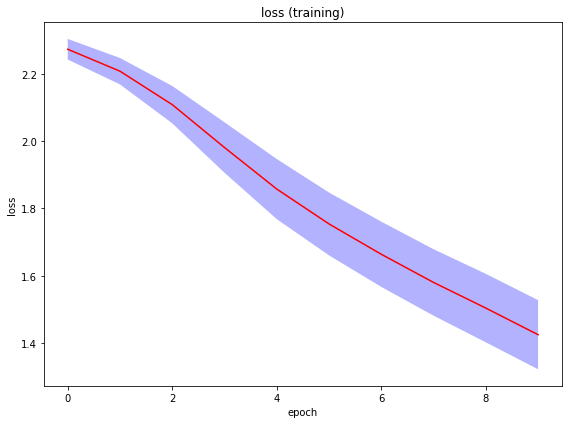

In [360]:
function_result_01()

## # 02. plot the training accuracy curve (mean, std)

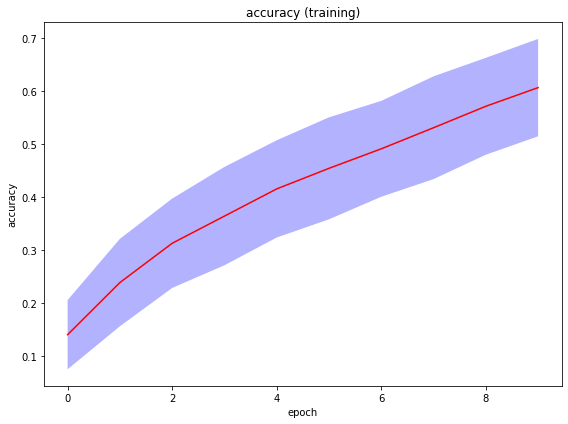

In [361]:
function_result_02()

## # 03. plot the testing loss curve (mean, std)

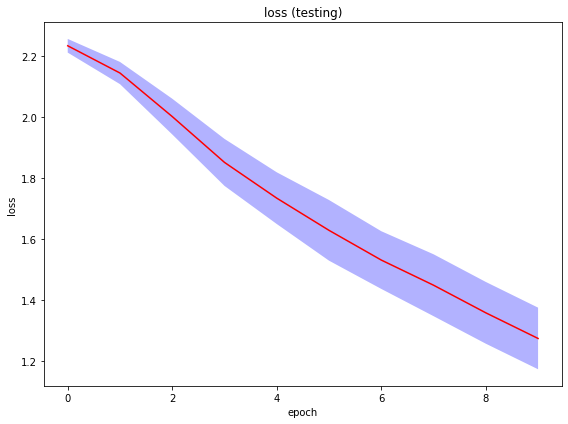

In [362]:
function_result_03()

## # 04. plot the testing accuracy curve (mean, std)

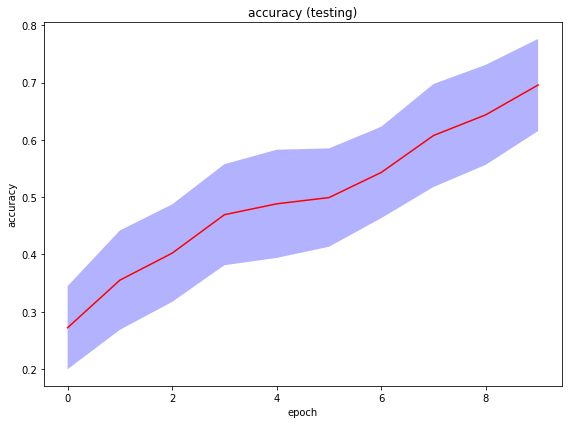

In [363]:
function_result_04()

## # 05. print the training (mean) loss over batches at last 10 epochs

In [364]:
function_result_05()

index =  0, value = 2.2737692703
index =  1, value = 2.2083848076
index =  2, value = 2.1089425220
index =  3, value = 1.9813579407
index =  4, value = 1.8578006025
index =  5, value = 1.7540617573
index =  6, value = 1.6638199402
index =  7, value = 1.5800815163
index =  8, value = 1.5037812857
index =  9, value = 1.4245682253


## # 06. print the training (mean) accuracy over batches at last 10 epochs

In [365]:
function_result_06()

index =  0, value = 0.1410000000
index =  1, value = 0.2392500000
index =  2, value = 0.3133500000
index =  3, value = 0.3646000000
index =  4, value = 0.4159000000
index =  5, value = 0.4547000000
index =  6, value = 0.4915000000
index =  7, value = 0.5312500000
index =  8, value = 0.5717000000
index =  9, value = 0.6069000000


## # 07. print the testing (mean) loss over batches at last 10 epochs

In [366]:
function_result_07()

index =  0, value = 2.2350491610
index =  1, value = 2.1454827595
index =  2, value = 2.0024478474
index =  3, value = 1.8518664150
index =  4, value = 1.7344224300
index =  5, value = 1.6286694260
index =  6, value = 1.5310521116
index =  7, value = 1.4484362130
index =  8, value = 1.3577348166
index =  9, value = 1.2735054243


## # 08. print the testing (mean) accuracy over batches at last 10 epochs

In [367]:
function_result_08()

index =  0, value = 0.2721250000
index =  1, value = 0.3551250000
index =  2, value = 0.4022500000
index =  3, value = 0.4693750000
index =  4, value = 0.4883750000
index =  5, value = 0.4992500000
index =  6, value = 0.5431250000
index =  7, value = 0.6076250000
index =  8, value = 0.6437500000
index =  9, value = 0.6957500000


## # 09. print the best training (mean) accuracy within the last 10 epochs

In [368]:
function_result_09()

best training accuracy = 0.6069000000


## # 10. print the best testing (mean) accuracy within the last 10 epochs

In [369]:
function_result_10()

best testing accuracy = 0.6957500000
